In [1]:

import pandas as pd, numpy as np
from itertools import product
import matplotlib.pyplot as plt
import json

# Load price data and cointegrated pairs
prices = pd.read_csv("../data/processed/aligned_prices2.csv",
                     index_col="Date", parse_dates=True)
with open("../data/processed/cointegrated_pairs.json") as f:
    coint_pairs = pd.DataFrame(json.load(f))  # DataFrame with columns A, B, beta


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def backtest_pair(prices, A, B, beta, entry_z, exit_z, cost_rate):
    """
    Simulate pair trading on stocks A and B. Positions:
      +1 = Long spread (long A, short B); -1 = Short spread (short A, long B); 0 = flat.
    Trades are entered when |Z| >= entry_z and exited when |Z| < exit_z.
    """
    # Compute spread and its Z-score
    spread = prices[A] - beta * prices[B]
    mu, sigma = spread.mean(), spread.std()
    z = (spread - mu) / sigma
    dates = spread.index
    n = len(dates)
    
    # Generate positions (0=flat, +1=long spread, -1=short spread)
    pos = np.zeros(n, int)
    for t in range(1, n):
        if pos[t-1] == 0:
            if z.iloc[t] >  entry_z:
                pos[t] = -1   # enter short spread
            elif z.iloc[t] < -entry_z:
                pos[t] = +1   # enter long spread
        else:
            # exit when Z returns within [-exit_z, +exit_z]
            pos[t] = 0 if abs(z.iloc[t]) < exit_z else pos[t-1]
    
    # Compute per-unit P&L and costs
    spread_diff = spread.diff().fillna(0).values
    pnl = pos[:-1] * spread_diff[1:]  # pnl on day t = position*(spread(t)-spread(t-1))
    trades = np.where(pos[1:] != pos[:-1])[0] + 1  # indices of entries/exits
    costs = np.zeros(n)
    for t in trades:
        # cost = cost_rate * (value of both legs)
        costs[t] = cost_rate * (prices[A].iloc[t] + beta * prices[B].iloc[t])
    pnl_net = pnl - costs[1:]  # subtract cost on trade days
    cum_pnl = np.concatenate([[0], np.cumsum(pnl_net)])  # cumulative per-unit pnl
    
    # Return detailed time series DataFrame
    return pd.DataFrame({
        "Spread": spread.values,
        "Z":      z.values,
        "Position": pos,
        "PnL_net": np.concatenate([[0], pnl_net]),  # include 0 at start
        "CumPnL":  cum_pnl,
        "Cost":    costs
    }, index=dates)


In [3]:
# Parameter grid
entry_grid = [1.5, 2.0, 2.5]
exit_grid  = [0.5, 1.0, 1.5]
cost_rate  = 0.0005   # 5 bps per leg
capital    = 100_000
per_pair_cap = capital / len(coint_pairs)  # capital allocated to each pair

results = []
for entry_z, exit_z in product(entry_grid, exit_grid):
    portfolio_pnl = np.zeros(len(prices))
    total_trades  = 0

    for _, pair in coint_pairs.iterrows():
        A, B, beta = pair.A, pair.B, pair.beta
        bt = backtest_pair(prices, A, B, beta, entry_z, exit_z, cost_rate)
        # Scale PnL by allocated capital: 1 spread-unit ≈ $base_val
        base_val = prices[A].iloc[0] + beta * prices[B].iloc[0]
        units = per_pair_cap / base_val
        portfolio_pnl += bt["PnL_net"].values * units
        # count number of trades (entries+exits)
        pos = bt["Position"].values
        trades_count = np.sum(pos[1:] != pos[:-1])
        total_trades += trades_count

    daily_ret = portfolio_pnl / capital
    total_ret = daily_ret.sum()
    sharpe    = daily_ret.mean() / (daily_ret.std() + 1e-9) * np.sqrt(252)
    results.append({
        "entry_z": entry_z,
        "exit_z":  exit_z,
        "trades":  total_trades,
        "return_%": total_ret * 100,
        "sharpe":  sharpe
    })

res_df = pd.DataFrame(results).set_index(["entry_z","exit_z"])
display(res_df["return_%"].unstack(level="exit_z"))
display(res_df["sharpe"].unstack(level="exit_z"))


exit_z,0.5,1.0,1.5
entry_z,,,
1.5,113.666968,93.528357,66.680534
2.0,68.432071,60.681824,41.148715
2.5,46.817212,42.801781,29.545178


exit_z,0.5,1.0,1.5
entry_z,,,
1.5,2.990993,3.099826,2.741895
2.0,2.148399,2.357619,2.106834
2.5,1.622916,1.889257,1.801055


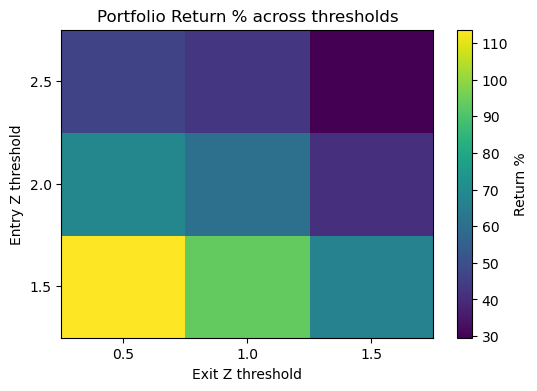

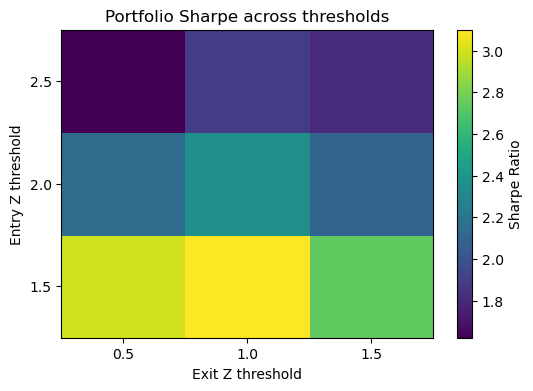

In [4]:
# Pivot results for plotting
ret_matrix    = res_df["return_%"].unstack()
sharpe_matrix = res_df["sharpe"].unstack()

plt.figure(figsize=(6,4))
plt.imshow(ret_matrix, aspect='auto', origin='lower')
plt.colorbar(label="Return %")
plt.xticks(range(len(ret_matrix.columns)), ret_matrix.columns)
plt.yticks(range(len(ret_matrix.index)), ret_matrix.index)
plt.xlabel("Exit Z threshold"); plt.ylabel("Entry Z threshold")
plt.title("Portfolio Return % across thresholds")
plt.show()

plt.figure(figsize=(6,4))
plt.imshow(sharpe_matrix, aspect='auto', origin='lower')
plt.colorbar(label="Sharpe Ratio")
plt.xticks(range(len(sharpe_matrix.columns)), sharpe_matrix.columns)
plt.yticks(range(len(sharpe_matrix.index)), sharpe_matrix.index)
plt.xlabel("Exit Z threshold"); plt.ylabel("Entry Z threshold")
plt.title("Portfolio Sharpe across thresholds")
plt.show()


Total Return: 113.67%
Annualized Sharpe: 2.99


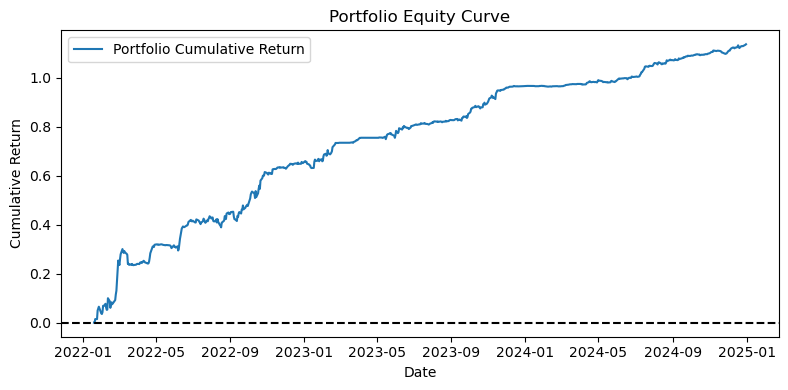

In [5]:
# Re-run backtest with selected thresholds
entry_z, exit_z = 1.5, 0.5
capital = 100_000
per_pair_cap = capital / len(coint_pairs)

portfolio_pnl = np.zeros(len(prices))
for _, pair in coint_pairs.iterrows():
    A, B, beta = pair.A, pair.B, pair.beta
    bt = backtest_pair(prices, A, B, beta, entry_z, exit_z, cost_rate)
    base_val = prices[A].iloc[0] + beta * prices[B].iloc[0]
    units = per_pair_cap / base_val
    portfolio_pnl += bt["PnL_net"].values * units

cum_return = np.cumsum(portfolio_pnl) / capital
# Annualized Sharpe and total return
daily_ret = portfolio_pnl / capital
sharpe = daily_ret.mean() / (daily_ret.std() + 1e-9) * np.sqrt(252)
total_return = cum_return[-1] * 100
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Sharpe: {sharpe:.2f}")

# Plot cumulative return (equity curve)
plt.figure(figsize=(8,4))
plt.plot(prices.index, cum_return, label="Portfolio Cumulative Return")
plt.axhline(0, color='k', ls='--')
plt.xlabel("Date"); plt.ylabel("Cumulative Return")
plt.title("Portfolio Equity Curve")
plt.legend()
plt.tight_layout()
plt.show()


We extract each individual trade (entry and exit) to analyze profitability, direction, and holding period. This produces a “trade blotter”. We reuse the backtest_pair data to find when positions go from flat to ±1 (entry) and back to 0 (exit).

In [6]:
def extract_trades(bt, A, B, beta, cap_per_pair):
    trades = []
    pos = bt["Position"].values
    dates = bt.index
    entry_idx, entry_pos = None, None
    
    for t in range(1, len(pos)):
        # Entry: flat -> ±1
        if pos[t-1] == 0 and pos[t] != 0:
            entry_idx = t
            entry_pos = pos[t]
            entry_dt = dates[t]
        # Exit: ±1 -> flat
        elif pos[t-1] != 0 and pos[t] == 0 and entry_idx is not None:
            exit_idx = t
            exit_dt  = dates[t]
            # Profit in spread units for this round-trip
            pnl_rt = bt["CumPnL"].iloc[exit_idx] - bt["CumPnL"].iloc[entry_idx]
            base_val = prices[A].iloc[entry_idx] + beta * prices[B].iloc[entry_idx]
            units = cap_per_pair / base_val
            pnl_dollars = pnl_rt * units
            trades.append({
                "Pair":        f"{A}-{B}",
                "EntryDate":   entry_dt,
                "ExitDate":    exit_dt,
                "Direction":   "LongSpread" if entry_pos==+1 else "ShortSpread",
                "PnL($)":      pnl_dollars,
                "Return(%)":   pnl_rt * 100,  # percent of spread volatility
                "DaysHeld":    (exit_dt - entry_dt).days
            })
            entry_idx = None  # reset for next trade
    return trades

# Build trade list and equity contributions
trades_list = []
equity = pd.Series(0.0, index=prices.index)
for _, pair in coint_pairs.iterrows():
    A, B, beta = pair.A, pair.B, pair.beta
    bt = backtest_pair(prices, A, B, beta, entry_z, exit_z, cost_rate)
    trades_list += extract_trades(bt, A, B, beta, per_pair_cap)
    # Add this pair's contribution to portfolio equity curve
    base_val = prices[A] + beta * prices[B]
    scale = per_pair_cap / base_val.iloc[0]
    equity = equity.add(bt["PnL_net"] * scale, fill_value=0.0)

trades_df = pd.DataFrame(trades_list)
trades_df.head(5)


,Pair,EntryDate,ExitDate,Direction,PnL($),Return(%),DaysHeld
0,ATO-KMI,2022-01-20,2022-02-25,LongSpread,64.374063,455.028646,36
1,ATO-KMI,2022-05-18,2022-05-24,LongSpread,63.069875,488.219736,6
2,ATO-KMI,2022-06-13,2022-06-23,LongSpread,72.190412,533.411205,10
3,ATO-KMI,2022-09-30,2022-11-18,LongSpread,89.092811,624.531362,49
4,ATO-KMI,2023-05-04,2023-08-14,ShortSpread,60.720095,481.378426,102


In [7]:
win_rate = (trades_df["PnL($)"] > 0).mean() * 100
avg_pnl = trades_df["PnL($)"].mean()
avg_days = trades_df["DaysHeld"].mean()
print(f"Win Rate: {win_rate:.1f}%")
print(f"Average PnL per trade: ${avg_pnl:.2f}")
print(f"Average holding period: {avg_days:.1f} days")


Win Rate: 96.0%
Average PnL per trade: $-36.55
Average holding period: 42.5 days


In [8]:
# Calculate returns and metrics
daily_ret = equity / capital
total_return = daily_ret.sum()
years = (prices.index[-1] - prices.index[0]).days / 365.25
sharpe = daily_ret.mean() / (daily_ret.std() + 1e-9) * np.sqrt(252)
cagr = (1 + total_return) ** (1/years) - 1
# Max drawdown
cum_eq = (equity.cumsum() / capital).values
running_max = np.maximum.accumulate(cum_eq)
drawdowns = cum_eq - running_max
max_dd = drawdowns.min()

metrics = {
    "Total Return (%)": total_return * 100,
    "Annualized Sharpe": sharpe,
    "CAGR (%)":        cagr * 100,
    "Win Rate (%)":    win_rate,
    "Max Drawdown (%)": max_dd * 100
}
pd.Series(metrics).round(2)


Total Return (%)     113.67
Annualized Sharpe      2.99
CAGR (%)              29.37
Win Rate (%)          96.02
Max Drawdown (%)      -6.57
dtype: float64

In [11]:
import pickle, os

# infer the period from strategy returns
start = daily_ret.index.min().strftime("%Y-%m-%d")
end   = daily_ret.index.max().strftime("%Y-%m-%d")

strategy_data = {
    "daily_ret": daily_ret,       # pandas Series of strategy daily returns
    "cum_return": cum_return,     # numpy array or pandas Series of cumulative returns
    "start": start,               # "YYYY-MM-DD"
    "end":   end,                 # "YYYY-MM-DD"
}

os.makedirs("../data/processed/", exist_ok=True)
with open("../data/processed/strategy_data2.pkl", "wb") as f:
    pickle.dump(strategy_data, f)

print(f" Saved strategy_data2.pkl for {start} through {end}")


 Saved strategy_data2.pkl for 2022-01-19 through 2024-12-31
